<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - UC3
Crop type feature engineering

In [2]:
import openeo
from openeo.processes import ProcessBuilder, array_modify, normalized_difference, drop_dimension, quantiles, sd, mean, array_apply, array_concat,array_create, if_
from openeo.rest.conversions import timeseries_json_to_pandas
from eo_utils import *
from matplotlib import pyplot as plt
from shapely.geometry import box
import pandas as pd
from helper import compute_indices

In this notebook we will do some data exploration for different types of crops, both spatially and temporally. First we will calculate a vegetation index and compare the greenness of several plots for an area selected on a map. After that, we will dive into different features that we can calculate using openeo that can be used for performing crop type classification.

Step 1: Select a polygon on the map below. For the sake of the analysis below, make sure your polygon covers just one land use type (for example, a forest, a field or a small group of fields).

In [95]:
center = [50.8, 4.75]
zoom = 13

eoMap = openeoMap(center,zoom)
addS2Tiles(eoMap)
eoMap.map

Map(center=[50.8, 4.75], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [195]:
bbox = eoMap.getBbox()

Fill in the land cover type that you think the polygon you selected contains.

In [73]:
lc_polygon = "Potato"
year = 2019

In [6]:
connection = openeo.connect("https://openeo-dev.vito.be")

In [181]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo-dev.vito.be/openeo/1.0/' with BearerAuth>

In [23]:
connection.describe_account()

{'info': {'acr': 'https://refeds.org/assurance/IAP/low',
  'eduperson_assurance': ['https://aai.egi.eu/LoA#Low',
   'https://refeds.org/assurance/IAP/low'],
  'email': 'jeroenddries@gmail.com',
  'email_verified': True,
  'sub': '30355e176b072c4954278c035a42221e356f77948d186d9abc87033919329887@egi.eu',
  'voperson_verified_email': ['jeroenddries@gmail.com']},
 'user_id': '30355e176b072c4954278c035a42221e356f77948d186d9abc87033919329887@egi.eu'}

## Load the dataset

Step 2: *Connect* to the vito backend and load bands 4 (RED), 8 (NIR) and the scene classification layer (SCL). This last layer will be used for cloud masking. The calculations will be done for the polygon you selected in the previous step, and it will take all images from 2018.
After that, use the scene classification band to perform *cloud masking* and we drop the SCL layer as we will not need it anymore.

In [182]:
temp_ext = [str(year-1)+"-11-01", str(year+1)+"-02-01"]

temporal_partition_options = {
        "indexreduction": 0,
        "temporalresolution": "None",
        "tilesize": 256
    }
default_partition_options = {
    "tilesize": 256
}

s2 = connection.load_collection("TERRASCOPE_S2_TOC_V2",                                 
                                temporal_extent=temp_ext, 
                                bands=["B04","B08","B11","SCL"])
s2._pg.arguments['featureflags'] = temporal_partition_options
s2_masked = s2.process("mask_scl_dilation", data=s2, scl_band_name="SCL")

In [183]:
s1 = connection.load_collection("S1_GRD_SIGMA0_ASCENDING",                                 
                                temporal_extent=[str(year)+"-01-01", str(year+1)+"-01-01"], 
                                bands=["VH","VV"]
                               )
s1._pg.arguments['featureflags'] = temporal_partition_options
composite_s1 = s1.aggregate_temporal_period(period="month", reducer="median")

Step 3: The next step is to create 10-day periods by reducing the timeseries using the median, and interpolate linearly the 10-day composites for which no data was available.

In [184]:
composite = s2_masked.aggregate_temporal_period(period="month", reducer="mean")
interpolated = composite.apply_dimension(dimension="t", process="array_interpolate_linear").filter_temporal([str(year)+"-01-01", str(year+1)+"-01-01"])


## Timeseries analysis of vegetation greenness

In this use case we want to have a look at vegetation greenness over time. Different land cover types can be identified by their seasonal greenup / greendown patterns. For example, coniferous forests are green all year round and have little variation in  greenness over time, while crops like sugar beet and maize are characterized by strong seasonal fluctuations. An overview of several crops types is displayed below.

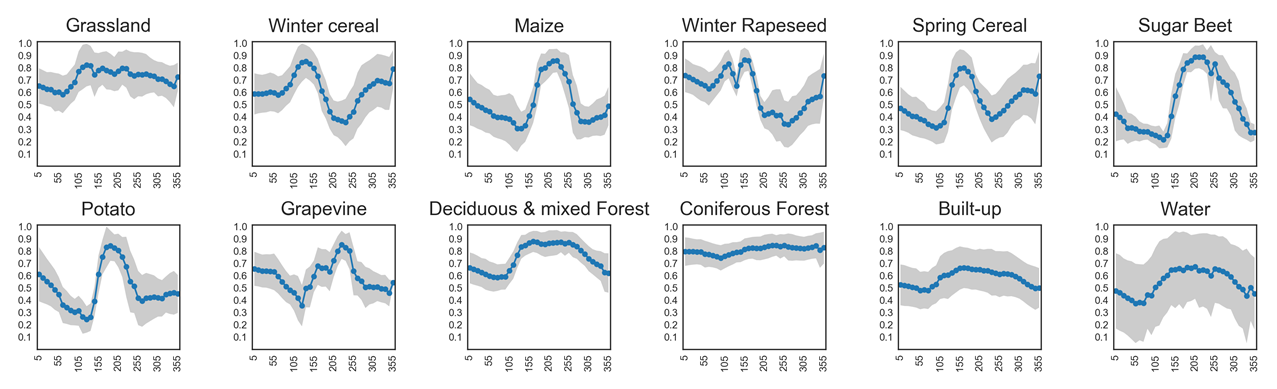

Step 4: To make a similar seasonal plot for the area you selected in the map above, we want to first calculate a vegetation index such as the NDVI or the EVI. To do so, we need to define a callback function that can be passed to the process parameter of apply_dimension.

In [ ]:
ndvi_comp = compute_indices(s2_masked, ["NDVI"])
extended_ndvi = ndvi_comp

Step 5: This NDVI is calculated for every pixel in every time step t in the masked NIR/red image that we extracted from SentinelHub. Now we want to aggregate the polygon you selected spatially to end up with a timeseries by calculating the mean over all the pixels as well as the standard deviation, to have an indication of the error. The more homogeneous the area you selected is, the smaller your error will be.

In [ ]:
timeseries = extended_ndvi.filter_bands([0]).aggregate_spatial(reducer="mean", geometries=box(*bbox)).execute()
timeseries_sd = extended_ndvi.filter_bands([0]).aggregate_spatial(reducer="sd", geometries=box(*bbox)).execute()

Finally, we can plot the mean and standard deviation for the plot you selected. Compare your results with the image above. Are your results as expected? Feel free to select a polygon on the map and run the code once more to compare your results.

In [ ]:
timeser = pd.concat([timeseries_json_to_pandas(timeseries),timeseries_json_to_pandas(timeseries_sd)], axis=1).dropna()
timeser.columns = ["Mean NDVI", "SD"]
timeser.index = pd.to_datetime(timeser.index)
timeser = timeser.sort_index()

plt.plot(timeser["Mean NDVI"],"o-")
plt.fill_between(timeser.index,
                 timeser["Mean NDVI"] - timeser["SD"], 
                 timeser["Mean NDVI"] + timeser["SD"],
                 color='gray', alpha=0.2)
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.title(lc_polygon)
plt.show()

### Reference dataset

For this use case, we use harmonized LPIS data from the ESA WorldCereal project.

The following crop types are of interest, with their code in the legend:
- maize 1200
- winter wheat 1110
- spring wheat 1120
- barley 1500
    - winter 1510
    - spring 1520
- potatos 5100
- sugar beet 8100
- rapeseed 4350
    - winter 4351
    - spring 4352
- sunflower 4380
- soy bean 4100


In [172]:
crops = {"maize":1200,"potatos":5100,"sugarbeet":8100,"barley":1500,"soy":4100}

In [ ]:
import geopandas as gpd
#original file not included, but this script was used for the extraction

df = gpd.read_file("2019_BE_LPIS-Flanders_POLY_110_full.json")
crop_samples = { k:df[df.CT==v].sample(10) for k,v in crops.items()}
for name,crop_df in crop_samples.items():
    crop_df.to_file("UC3_resources/"+ name + "_2019.geojson", driver='GeoJSON')

In [176]:
#load samples
crop_samples = {name:gpd.read_file("UC3_resources/"+ name + "_2019.geojson", driver='GeoJSON') for name,code in crops.items()}
    

### Retrieve timeseries
Extract NDVI and SAR timeseries for samples, this allows us to determine crop calendar rules.

After the extraction, we plot the timeseries profile so we can define good criteria to detect a given type of crop.

In [117]:

for name,crop_df in crop_samples.items():    
    extended_ndvi.aggregate_spatial(reducer="mean", geometries=crop_df.__geo_interface__).download("data/" + name + "_mean_NDVI.json")

In [151]:
for name,crop_df in crop_samples.items():    
    composite_s1.aggregate_spatial(reducer="mean", geometries=crop_df.__geo_interface__).download("data/" + name + "_mean_SAR.json")
 

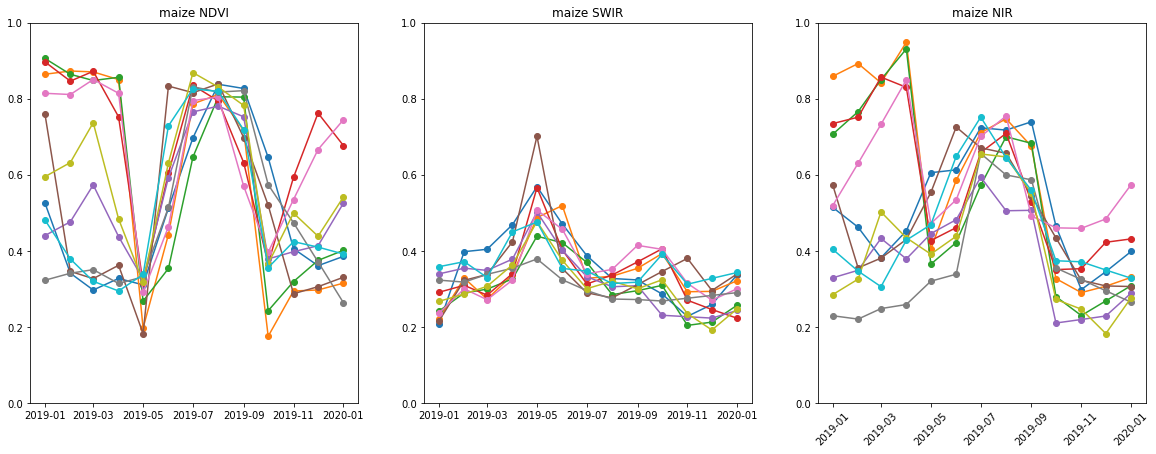

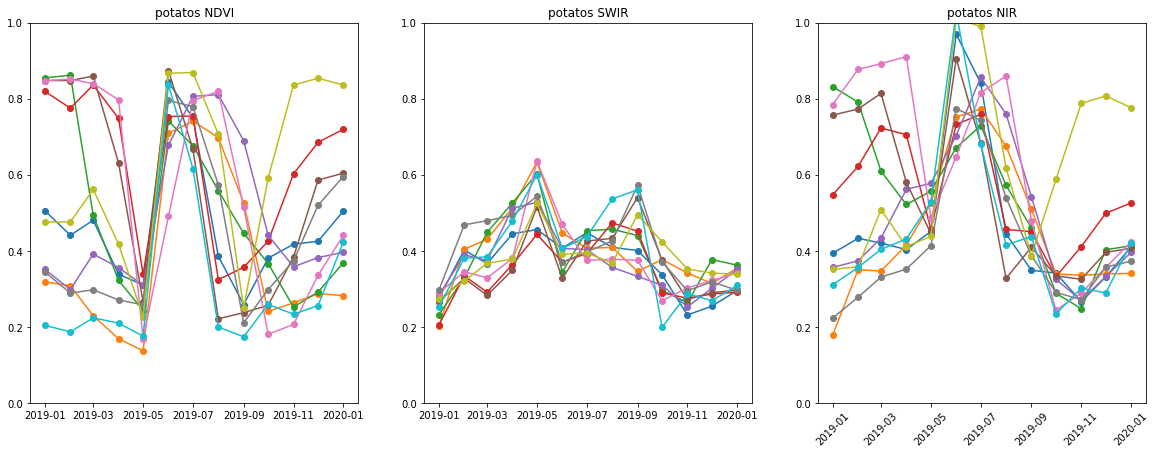

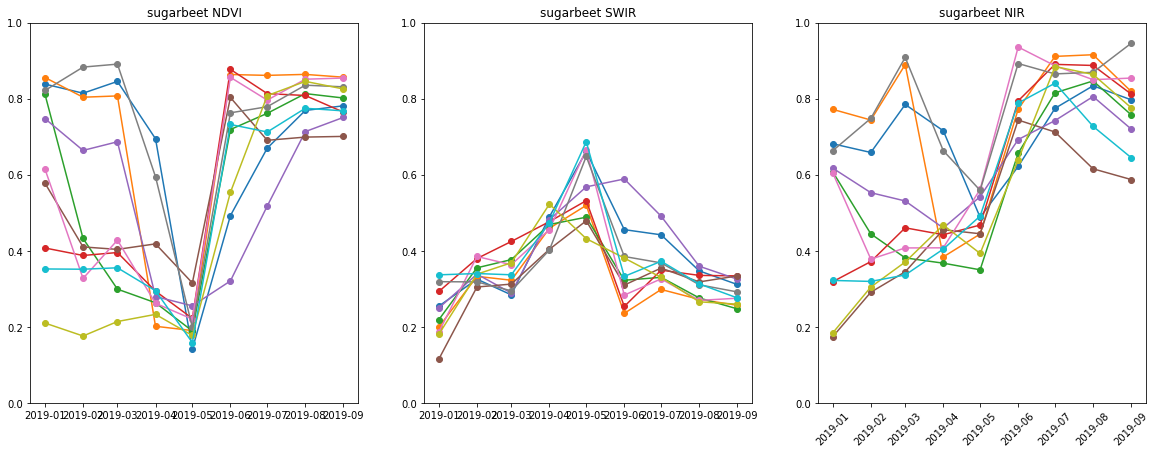

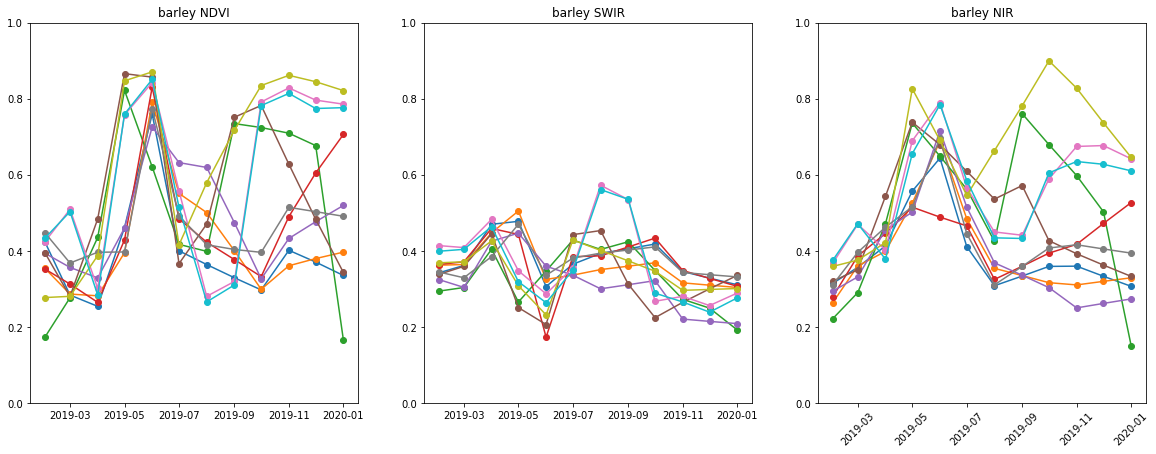

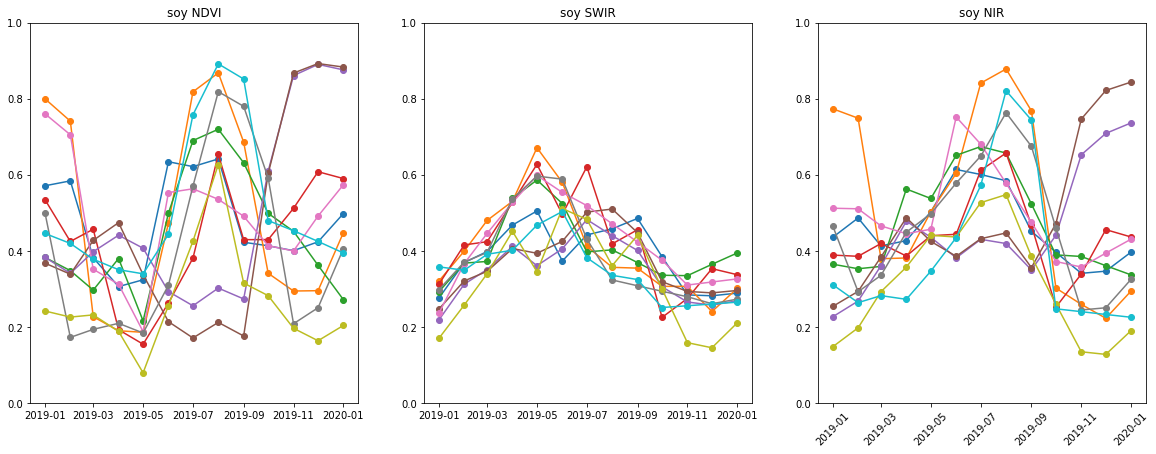

In [155]:

for name,crop_df in crop_samples.items(): 
    file = "data/" + name + "_mean_NDVI.json"
    with open(file) as f:
        ts_json = json.load(f)
    timeser = timeseries_json_to_pandas(ts_json).dropna()
    
    timeser.index = pd.to_datetime(timeser.index)
    timeser = timeser.sort_index()
    
    NDVI = timeser.xs(0, level='band', axis=1)
    NIR = timeser.xs(2, level='band', axis=1)/6000
    SWIR = timeser.xs(3, level='band', axis=1)/6000
    fig, (ax1, ax2,ax3) = plt.subplots(1,3)
    fig.set_figheight(7); fig.set_figwidth(20)
    ax1.plot(NDVI,"o-")
    ax1.set_ylim(0,1)
    plt.xticks(rotation=45)
    ax1.set_title(name + " NDVI")
    fig.show()
    
    ax2.plot(SWIR,"o-")
    
    ax2.set_ylim(0,1)
    plt.xticks(rotation=45)
    ax2.set_title(name + " SWIR")
    
    ax3.plot(NIR,"o-")
    
    ax3.set_ylim(0,1)
    plt.xticks(rotation=45)
    ax3.set_title(name + " NIR")
    fig.show()
    
    

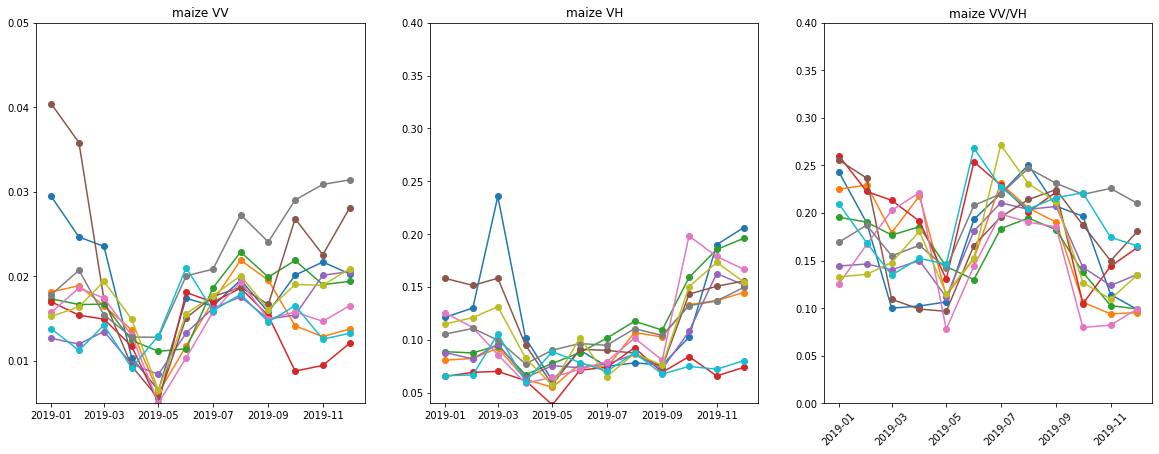

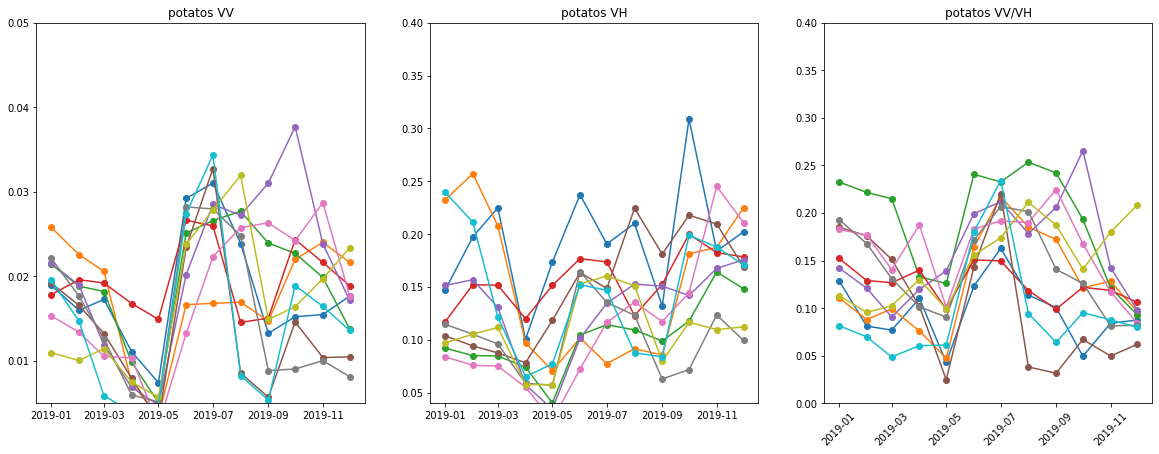

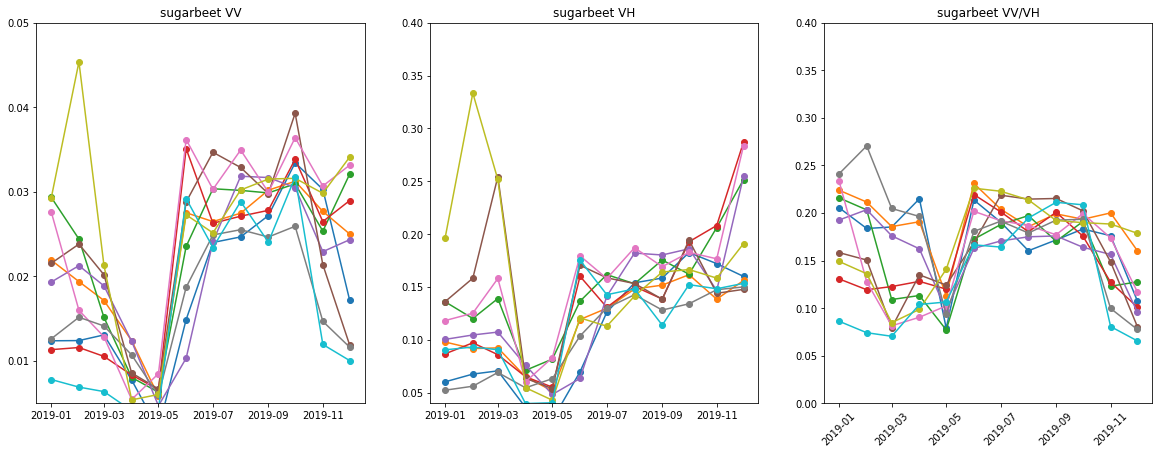

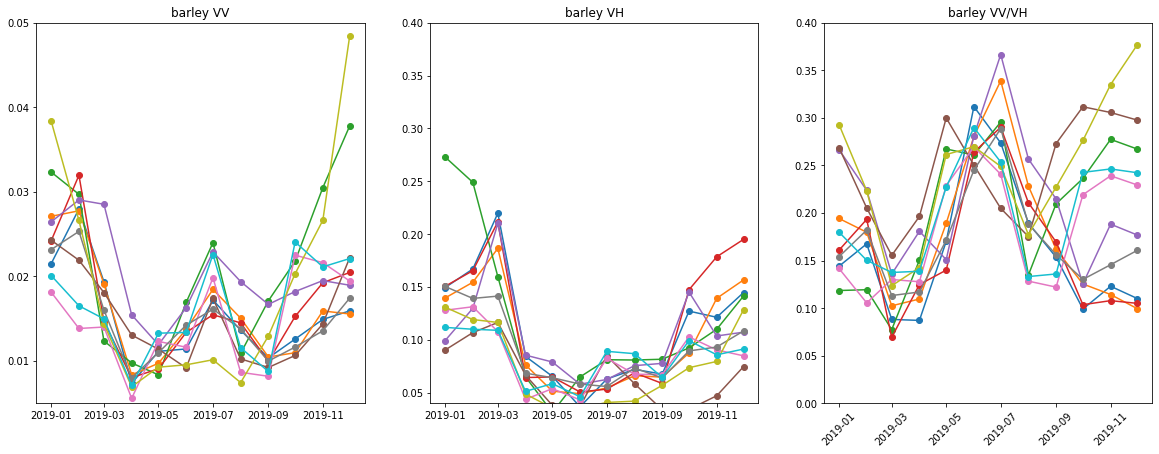

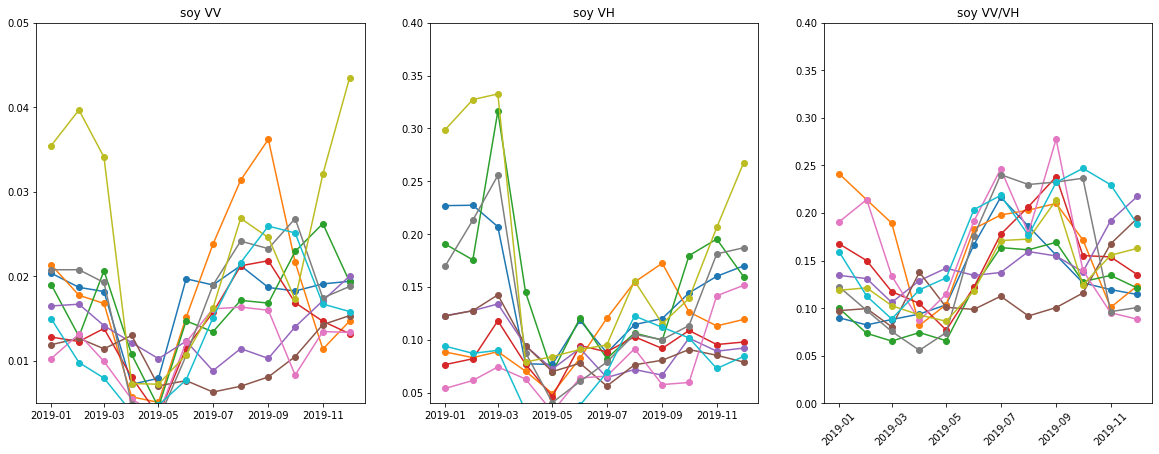

In [161]:
for name,crop_df in crop_samples.items(): 
    file = "data/" + name + "_mean_SAR.json"
    with open(file) as f:
        ts_json = json.load(f)
    timeser = timeseries_json_to_pandas(ts_json).dropna()
    
    timeser.index = pd.to_datetime(timeser.index)
    timeser = timeser.sort_index()
    
    VV = timeser.xs(0, level='band', axis=1)
    VH = timeser.xs(1, level='band', axis=1)
    VV_VH = VV/VH
    fig, (ax1, ax2,ax3) = plt.subplots(1,3)
    fig.set_figheight(7); fig.set_figwidth(20)
    ax1.plot(VV,"o-")
    ax1.set_ylim(0.005,0.05)
    plt.xticks(rotation=45)
    ax1.set_title(name + " VV")
    fig.show()
    
    ax2.plot(VH,"o-")
    
    ax2.set_ylim(0.04,0.4)
    plt.xticks(rotation=45)
    ax2.set_title(name + " VH")
    
    ax3.plot(VV_VH,"o-")
    
    ax3.set_ylim(0,0.4)
    plt.xticks(rotation=45)
    ax3.set_title(name + " VV/VH")
    fig.show()

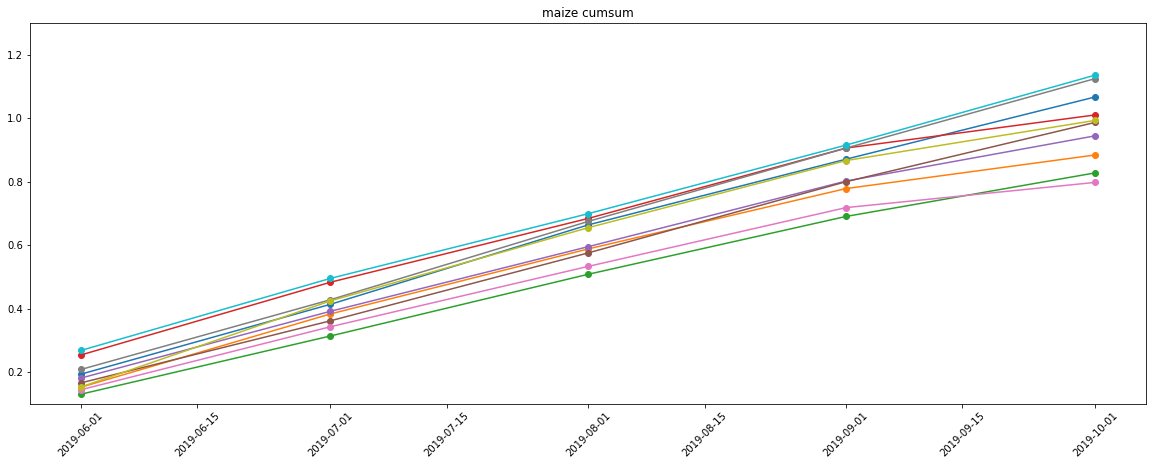

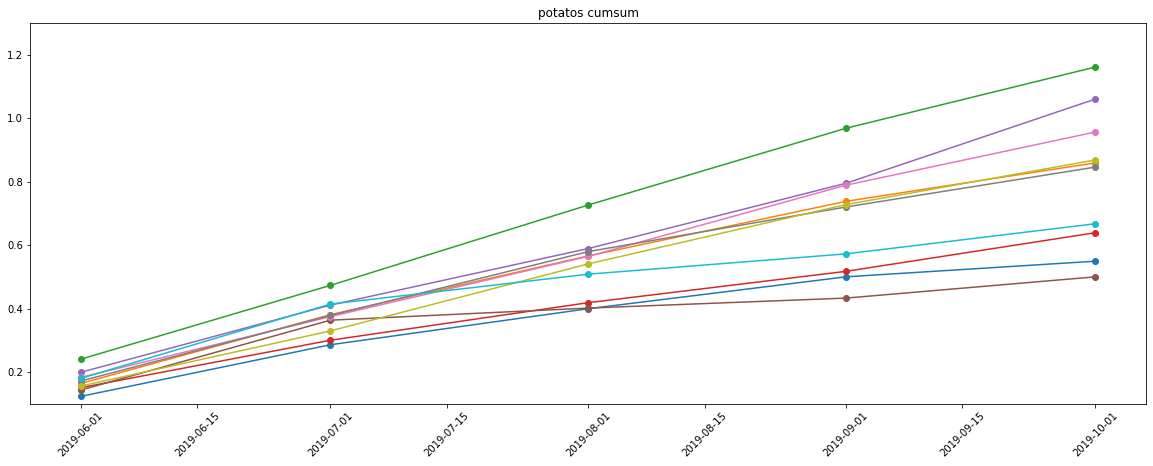

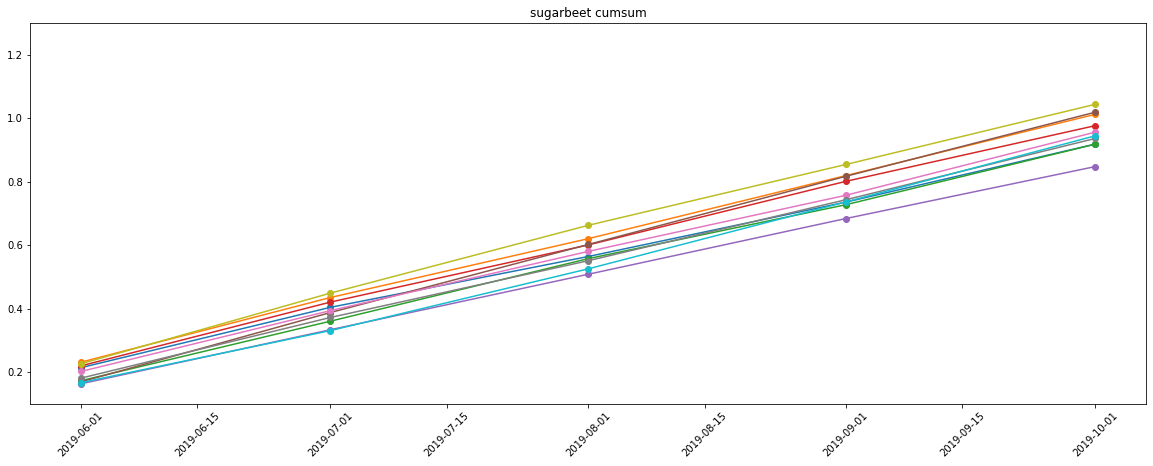

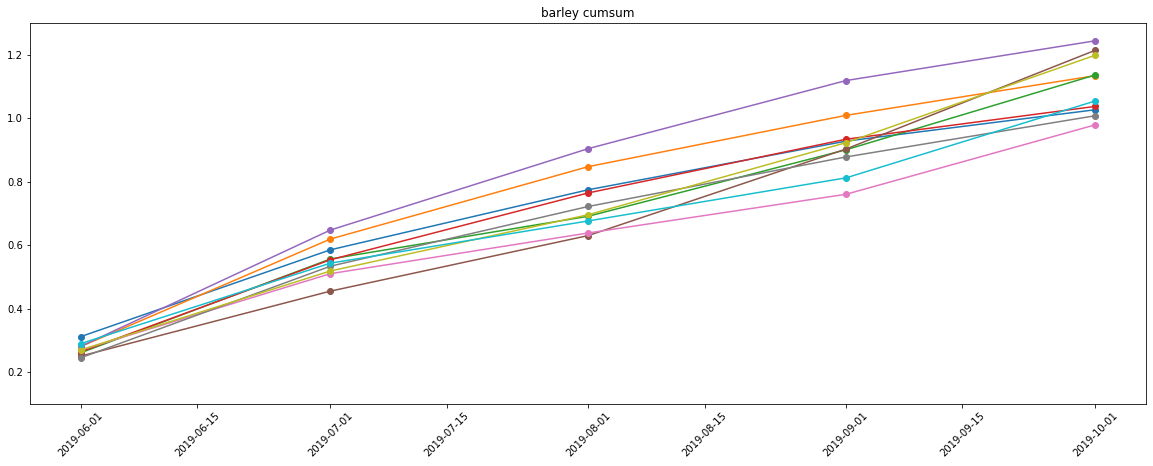

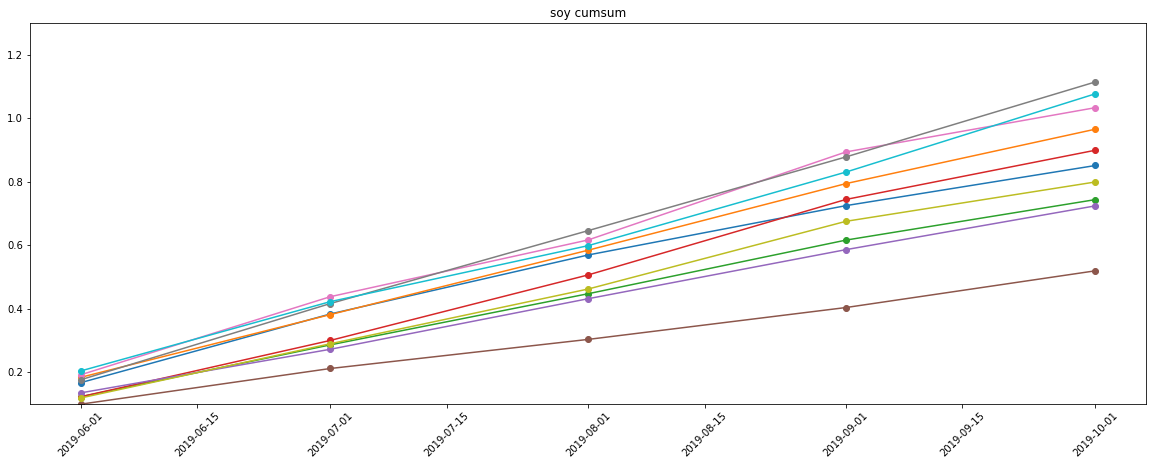

In [171]:
for name,crop_df in crop_samples.items(): 
    file = "data/" + name + "_mean_SAR.json"
    with open(file) as f:
        ts_json = json.load(f)
    timeser = timeseries_json_to_pandas(ts_json).dropna()
    
    timeser.index = pd.to_datetime(timeser.index)
    timeser = timeser.sort_index()
    
    VV = timeser.xs(0, level='band', axis=1)
    VH = timeser.xs(1, level='band', axis=1)
    VV_VH = VV/VH
    #print(name)
    sum = VV_VH["2019-06-01":"2019-10-01"].cumsum()
    fig, (ax1) = plt.subplots(1,1)
    fig.set_figheight(7); fig.set_figwidth(20)
    ax1.plot(sum,"o-")
    ax1.set_ylim(0.1,1.3)
    plt.xticks(rotation=45)
    ax1.set_title(name + " cumsum")
    fig.show()

In [ ]:
plt.plot(timeser["Mean NDVI"],"o-")
plt.fill_between(timeser.index,
                 timeser["Mean NDVI"] - timeser["SD"], 
                 timeser["Mean NDVI"] + timeser["SD"],
                 color='gray', alpha=0.2)
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.title(lc_polygon)
plt.show()

## Rule based stratification

First we add the NDVI index next to the loaded bands. We do this before compositing, to avoid computing an NDVI on unobserved band combinations.

In [186]:
ndvi_comp = compute_indices(s2_masked, ["NDVI"])

### SAR data

In [149]:

composite_s1=composite_s1.apply(lambda x:x.linear_scale_range(-0.5,0.0,0,2000))
composite_s1=composite_s1.resample_cube_spatial(ndvi_comp)
ndvi_comp_sar = ndvi_comp.merge_cubes(composite_s1)

### Performance optimization

After computing the NDVI, our datacube is holding double precision floating point numbers, at 8bytes per value. This requires a lot of memory in subsequent steps.
We scale the back to byte values, which only use 1 byte. Using 2-byte integers would also be an option if 1 byte is not sufficient.

This optimization can not be done automatically, because openEO is not aware of the desired precision.

In [192]:
ndvi_comp_byte = ndvi_comp.linear_scale_range(1,2000,0,250)

### Gap free composite

In [193]:
agg_month = ndvi_comp_byte.aggregate_temporal_period(period="month", reducer="mean")
ndvi_month = agg_month.apply_dimension(dimension="t", process="array_interpolate_linear").filter_temporal([str(year)+"-01-01", str(year)+"-12-31"])

### Crop detection rules

In this use case, we have defined so called 'expert rules' based on crop calendars and an analysis of time series profiles, to determine a crop type based on temporal behaviour.

The rules in this notebook have not been validated, and were mostly verified in Belgium. Crop calendar based rules are region depended, and can even change over time for the same region.


In [198]:
all_bands = ndvi_month.apply_dimension(dimension='t', target_dimension='bands', process=lambda x: x*1)
bandnames2 = [band + "_" + stat for stat in ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"] for band in all_bands.metadata.band_names]
bandnames = [band + "_" + stat for band in all_bands.metadata.band_names for stat in ["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]]
all_bands = all_bands.rename_labels('bands', target=bandnames)

ndvi_apr = all_bands.band("NDVI_apr")
ndvi_may = all_bands.band("NDVI_may")
ndvi_jun = all_bands.band("NDVI_jun")
ndvi_jul = all_bands.band("NDVI_jul")
ndvi_aug = all_bands.band("NDVI_aug")
ndvi_sep = all_bands.band("NDVI_sep")
ndvi_nov = all_bands.band("NDVI_nov")

nir_mar = all_bands.band("B08_mar")
nir_may = all_bands.band("B08_may")
swir_mar = all_bands.band("B11_mar")
swir_may = all_bands.band("B11_may")
    
    ##rule for corn is not in line with experiment for 2019, use ndvi_may < ndvi_jun??
corn = ((ndvi_may < ndvi_jun) + (ndvi_sep > ndvi_nov) + (nir_mar > swir_may) + (swir_mar > nir_may)) > 2
barley = ((ndvi_apr < ndvi_may) + (ndvi_jul < ndvi_jun)) == 2 ## barley has very narrow and early NDVI 
sugarbeet = ((ndvi_may < 0.6*ndvi_jun) + ((ndvi_jun+ndvi_jul+ndvi_aug+ndvi_sep)/4 > 0.7))==2 #4 month period of high NDVI

total = corn + 10*barley + 100*sugarbeet #allow multiple crops to be detected...
#

In [199]:
total.filter_bbox({'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]})\
    .download("./data/corn.tiff",format="GTiff")

In [ ]:

job = corn.execute_batch(out_format="netCDF")
# results = job.get_results()

## Feature selection for crop type mapping

For the final use case, the following crop types need to be mapped: 

* Summer cereal (= spring wheat, spring barley, spring rye, oats) 
* Winter cereal (= winter wheat, winter barley, winter rye) 
* Maize 
* Potato 
* Sugar beet 
* Rapeseed (= winter + spring rapeseed) 

A separability analysis was conducted based on the reference data currently available in the WorldCereal Common Input Baseline. We only focused on European reference data (i.e. LPIS and SIGPAC data). All classification features currently supported by the WorldCereal system were tested. Separability was first computed for each crop type separately in a binary one-vs-all case. Afterwards, an average separability of each feature was computed and features were ranked accordingly. Based on the ranking of features for individual crop types, the overall ranking for all types and ease of implementation, a proposal is made of features to be included for the openEO CCN.  

Attention! In WorldCereal, all features are normalized using the growing degree days approach. This has been proven to significantly increase robustness of classification features across space and time. For openEO CCN, this normalization step is probably less crucial, as the study is “limited” to Europe only. Just bear in mind that feature separability was also computed based on normalized features, so results might not entirely be applicable. Still, the main results and conclusions are expected to be the same between normalized and non-normalized case. 

**Sentinel-2 features**
For the final feature selection, the following timeseries should be computed/derived (see satio.rsindices for definitions of the band combinations mentioned below) from Sentinel-2:
* B06 
* B12 
* NDVI 
* NDMI 
* NDGI 
* ANIR 
* NDRE1 
* NDRE2 
* NDRE5 

Based on all these timeseries, the following features should be computed: 
* Percentiles (p10, p50, p90) 
* Standard deviation 
* Tsteps. This results in a set of 6 features. Ts0, ts1, ts2, ts3, ts4 and ts5, of which ts0, ts1 and ts5 are the most important ones. The others can be dropped to limit the total number of features to be used. 

**Sentinel-1 features**
Timeseries to be derived from sentinel-1 data: 
* VV 
* VH 
* VH/VV ratio 

Features to be computed on these timeseries (ordered from high to lower importance): 
* Percentiles (p10, p50, p90) 
* Tsteps
* Standard deviation 

**Other features**
* Altitude derived from Copernicus 30m DEM
* Derived from AgERA5 meteo data: Sum of precipitation over growing season
* P10, p50 and p90 of mean temperature 


## Feature computation

We will already calculate some of these features here and plot them.

Features are generally computed over the temporal dimension, and result in multiple bands being added. In the openEO API, the 'apply_dimension' process 
allows us to work on the temporal dimension, and store the result in the bands dimension.

In [33]:
indices = compute_indices(interpolated, ["NDVI","NDMI"])

In [34]:
indices.download("./data/indices.nc", format="netCDF")

In [ ]:
indices_ds = xr.open_dataset("./data/indices.nc",engine="h5netcdf")
indices_ds['B04'] = indices_ds.B04/10000
indices_ds['B08'] = indices_ds.B08/10000
indices_ds.to_array().sel(t="2018-10-01")

In [ ]:
indices_ds.to_array().sel(t="2018-10-01").sel(variable=['B04','B08','NDVI','NDMI']).hvplot(x='x',y='y',by='variable',subplots=True,width = 300,dynamic=False,colorbar=False,cmap="YlGn")

In [37]:
def computeStats(input_timeseries:ProcessBuilder):
    tsteps = list([input_timeseries.array_element(6*index) for index in range(0,6)])
    return array_concat(array_concat(input_timeseries.quantiles(probabilities=[0.1,0.5,0.9]),[input_timeseries.mean(), input_timeseries.sd()]),tsteps).linear_scale_range(0,2000,0,250)


features = indices.apply_dimension(dimension='t',target_dimension='bands', process=computeStats)

tstep_labels = [ "t"+ str(6*index) for index in range(0,6) ]
features = features.rename_labels('bands',[band + "_" + stat for band in indices.metadata.band_names for stat in ["p10","p50","p90","mean","sd"] + tstep_labels ])



features.download("./data/mean_sd.nc", format="netCDF")

In [39]:
import hvplot.xarray
features_ds = xr.open_dataset("./data/mean_sd.nc",engine="h5netcdf")

features_ds

<xarray.Dataset>
Dimensions:    (x: 256, y: 256)
Coordinates:
  * x          (x) float64 6.221e+05 6.221e+05 6.221e+05 ... 6.246e+05 6.246e+05
  * y          (y) float64 5.63e+06 5.63e+06 5.63e+06 ... 5.627e+06 5.627e+06
Data variables:
    crs        |S1 ...
    B04_p10    (y, x) uint8 ...
    B04_p50    (y, x) uint8 ...
    B04_p90    (y, x) uint8 ...
    B04_mean   (y, x) uint8 ...
    B04_sd     (y, x) uint8 ...
    B04_t0     (y, x) uint8 ...
    B04_t6     (y, x) uint8 ...
    B04_t12    (y, x) uint8 ...
    B04_t18    (y, x) uint8 ...
    B04_t24    (y, x) uint8 ...
    B08_p10    (y, x) uint8 ...
    B08_p50    (y, x) uint8 ...
    B08_p90    (y, x) uint8 ...
    B08_mean   (y, x) uint8 ...
    B08_sd     (y, x) uint8 ...
    B08_t0     (y, x) uint8 ...
    B08_t6     (y, x) uint8 ...
    B08_t12    (y, x) uint8 ...
    B08_t18    (y, x) uint8 ...
    B08_t24    (y, x) uint8 ...
    B11_p10    (y, x) uint8 ...
    B11_p50    (y, x) uint8 ...
    B11_p90    (y, x) uint8 ...
    

In [40]:
features_ds.to_array().sel(variable=['B04_p50','B08_p50','NDVI_p50','NDMI_p50']).hvplot(x='x',y='y',by='variable',subplots=True,width = 300,dynamic=False,colorbar=False,cmap="YlGn")

:NdLayout   [variable]
   :Image   [x,y]   (value)

In [ ]:
features_ds.to_array()

In [ ]:
s1 = connection.load_collection("TERRASCOPE_S1_GAMMA0_V1", 
                                spatial_extent={'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}, 
                                temporal_extent=["2018-01-01", "2019-01-01"], 
                                bands=["VH","VV"])
composite_s1 = s1.aggregate_temporal_period(period="dekad", reducer="median")
interpolated_s1 = composite_s1.apply_dimension(dimension="t", process="array_interpolate_linear")

In [ ]:
sd = interpolated_s1.apply_dimension(dimension="t", process=sd)
mean = interpolated_s1.apply_dimension(dimension="t", process=mean)

In [ ]:
%time mean.download("./data/mean_gamma0.tif", format="GTiff")
%time sd.download("./data/sd_gamma0.tif", format="GTiff")

In [ ]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl

tifs = ["mean_gamma0", "sd_gamma0"]

for i in tifs:
    with rasterio.open('./data/'+i+'.tif',mode="r+",crs=rasterio.crs.CRS({"init": "epsg:4326"})) as dataset:
        (min1, max1), (min2, max2) = [(np.min(i[:-1]), np.max(i[:-1])) for i in dataset.read()]
        axmin = min(min1,min2); axmax = max(max1,max2)
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_figheight(14); fig.set_figwidth(14)
        ax1.yaxis.set_major_formatter(FormatStrFormatter('%.3f')); ax1.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f')); ax2.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        cmap = mpl.cm.YlGn
        ax1.imshow(dataset.read(1)[:-1], cmap=cmap, extent=[bbox[0],bbox[2],bbox[1],bbox[3]])
        ax2.imshow(dataset.read(2)[:-1], cmap=cmap, extent=[bbox[0],bbox[2],bbox[1],bbox[3]])
        plt.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min1, vmax=max1), cmap=cmap), location="right", orientation="vertical",shrink=.15,ax=ax1)
        plt.colorbar(mappable=mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min2, vmax=max2), cmap=cmap), location="right", orientation="vertical",shrink=.15,ax=ax2)
        ax1.title.set_text(i+' VH')
        ax2.title.set_text(i+' VV')
        plt.show()

## Dataset sampling

Once we have our features defined, we will want to generate a set of input features for model calibration. Instead of calculating features
for a very large area, openEO can sample the datacube at selected locations.

Sampling a datacube in openEO currently requires polygons as sampling features. Other types of geometry, like lines
and points, should be converted into polygons first by applying a buffering operation. Using the spatial resolution
of the datacube as buffer size can be a way to approximate sampling at a point.

To indicate to openEO that we only want to compute the datacube for certain polygon features, we use the
`~openeo.rest.datacube.DataCube.filter_spatial` method.

Next to that, we will also indicate that we want to write multiple output files. This is more convenient, as we will
want to have one or more raster outputs per sampling feature, for convenient further processing. To do this, we set
the 'sample_by_feature' output format property, which is available for the netCDF and GTiff output formats.

Combining all of this, results in the following sample code:




In [ ]:
sampled_features = features.filter_spatial("https://artifactory.vgt.vito.be/testdata-public/parcels/test_10.geojson")
job = sampled_features.send_job(title="Sentinel2", description="Sentinel-2 features",out_format="netCDF",sample_by_feature=True)

Sampling only works for batch jobs, because it results in multiple output files, which can not be conveniently transferred
in a synchronous call.
